# **Data Availability**

The data for this project comes from a study called "Transcriptional, behavioural and biochemical profiling in the 3xTg-AD mouse model reveals a specific signature of amyloid deposition and functional decline in Alzheimer’s disease," which is accessible via the Gene Expression Omnibus (GEO) via the following accession number: [GSE161904](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE161904).

In this project we'll analyze bulk RNA-sequencing data from the insular cortex of three 3xTG-AD trasgenic mice and three wild type mice control littermates at five discrete time points (2, 7, 8, 11, and 14 months of age). Additional information about this dataset is provided below:

- **GEO Accension Number:** GSE161904
- **Data type:** Bulk RNA-seq
- **Tissue type:** Insular cortex
- **Mouse Strains:** 3xTg-AD transgenic mice and wid type mice (WT)
- **Age:** Mice were sampled at 2, 7, 8, 11, and 14 months old.
- **Genome build:** mm10
- **Total Samples:** 30 mice (3 transgenic mice x 3 WT mice x 5 time points)

**Note:** To collect samples mice were euthanized. Following euthanization the insular cortex was bilaterally dissected and tissue from both hemispheres was aggregated into a single sample per animal. Over the course of the study samples were taken from a total of 30 male mice, including three 3xTG-AD mutant mice and wild type mice at each postnatal stage (2,7,8,11, and 14 months).

# **Import Libraries**

Before loading the data above, I'll first import the following Python libraries, which will be used in downstream analyses:

In [3]:
!pip install mygene

In [4]:
!pip install gprofiler-official

In [5]:
import pandas as pd
import mygene
import numpy as np
from gprofiler import GProfiler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# **Load, Inspect, and Prepare Data**

Next, we'll use Bash's wget command to retrieve our bulk RNA-seq data, and following that, we'll use the Bash gunzip command to decompress the files:

In [6]:
!wget -O GSE161904_Raw_gene_counts_cortex.txt.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE161904&format=file&file=GSE161904%5FRaw%5Fgene%5Fcounts%5Fcortex%2Etxt%2Egz'

--2024-10-31 19:46:56--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE161904&format=file&file=GSE161904%5FRaw%5Fgene%5Fcounts%5Fcortex%2Etxt%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1482149 (1.4M) [application/octet-stream]
Saving to: ‘GSE161904_Raw_gene_counts_cortex.txt.gz’

GSE161904_Raw_gene_ 100%[===================>]   1.41M  2.85MB/s    in 0.5s    

2024-10-31 19:46:57 (2.85 MB/s) - ‘GSE161904_Raw_gene_counts_cortex.txt.gz’ saved [1482149/1482149]



In [7]:
!gunzip GSE161904_Raw_gene_counts_cortex.txt.gz

Following that, we'll load the data into a Pandas DataFrame and inspect the first 5 rows of data.

In [8]:
# Load the data from the txt file and convert it to a CSV
data = pd.read_csv("GSE161904_Raw_gene_counts_cortex.txt", sep="\t")
data.to_csv("GSE161904_Raw_gene_counts_cortex.csv", index=False)
data.head()

,G3R1_Cortex_3xTgAD,G1R2_Cortex_3xTgAD,G1R3_Cortex_3xTgAD,G1R4_Cortex_3xTgAD,G1R5_Cortex_WT,G1R6_Cortex_WT,G1R7_Cortex_WT,G4R1_Cortex_3xTgAD,G4R2_Cortex_3xTgAD,G4R3_Cortex_3xTgAD,...,G3R4_Cortex_3xTgAD,G2R4_Cortex_WT,G2R5_Cortex_3xTgAD,G2R6_Cortex_3xTgAD,G2R7_Cortex_3xTgAD,G3R10_Cortex_WT,G2R2_Cortex_WT,G2R3_Cortex_WT,G3R7_Cortex_WT,G3R9_Cortex_WT
ENSMUSG00000000001,1020,966,1024,1104,862,1120,1007,940,848,1004,...,1203,1309,1100,1208,1321,1225,1185,778,1116,1106
ENSMUSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028,63,71,75,70,56,78,61,52,60,79,...,59,100,60,65,70,90,94,32,69,97
ENSMUSG00000000031,3,0,0,1,0,2,1,0,0,0,...,3,2,1,1,0,0,0,1,2,1
ENSMUSG00000000037,91,61,61,67,77,91,61,54,29,44,...,73,130,83,82,100,111,139,77,72,125


The data above is indexed by Ensemble gene ID (ENSMUSG) with 30 columns of RNA-sequencing expression data (i.e., counts). Before performing downstream analyses we'll want to convert the Ensemble gene IDs to gene names, rename the columns based on the sample group (AD vs. WT) and time points (2,7,8,11, or 14mo), then rearrange the columns so they are ordered by sequentially and by group.

First, we'll begin by renaming and reordering the columns, as demonstrated in the code block below:

In [9]:
# define the current column names and new column names
current_columns = ["G3R1_Cortex_3xTgAD", "G1R2_Cortex_3xTgAD", "G1R3_Cortex_3xTgAD", "G1R4_Cortex_3xTgAD","G1R5_Cortex_WT", "G1R6_Cortex_WT", "G1R7_Cortex_WT", "G4R1_Cortex_3xTgAD","G4R2_Cortex_3xTgAD", "G4R3_Cortex_3xTgAD", "G3R3_Cortex_3xTgAD", "G4R5_Cortex_WT","G4R6_Cortex_WT", "G4R7_Cortex_WT", "G5R1_Cortex_3xTgAD", "G5R2_Cortex_3xTgAD","G5R3_Cortex_3xTgAD", "G5R4_Cortex_WT", "G5R6_Cortex_WT", "G5R5_Cortex_WT","G3R4_Cortex_3xTgAD", "G2R4_Cortex_WT", "G2R5_Cortex_3xTgAD", "G2R6_Cortex_3xTgAD","G2R7_Cortex_3xTgAD", "G3R10_Cortex_WT", "G2R2_Cortex_WT", "G2R3_Cortex_WT","G3R7_Cortex_WT", "G3R9_Cortex_WT"]

new_columns = ["AD1_8mo", "AD1_2mo", "AD2_2mo", "AD3_2mo", "WT1_2mo", "WT2_2mo", "WT3_2mo","AD1_11mo", "AD2_11mo", "AD3_11mo", "AD2_8mo", "WT1_11mo", "WT2_11mo", "WT3_11mo","AD1_14mo", "AD2_14mo", "AD3_14mo", "WT1_14mo", "WT2_14mo", "WT3_14mo", "AD3_8mo","WT3_7mo", "AD1_7mo", "AD2_7mo", "AD3_7mo", "WT3_8mo", "WT1_7mo", "WT2_7mo","WT1_8mo", "WT2_8mo"]

# create dictionary to map current columns names to new column names
column_mapping = dict(zip(current_columns, new_columns))

# rename the columns
data.rename(columns=column_mapping, inplace=True)

# define the desired column order
new_column_order = [
    "WT1_2mo", "WT2_2mo", "WT3_2mo", "AD1_2mo", "AD2_2mo", "AD3_2mo",
    "WT1_7mo", "WT2_7mo", "WT3_7mo", "AD1_7mo", "AD2_7mo", "AD3_7mo",
    "WT1_8mo", "WT2_8mo", "WT3_8mo", "AD1_8mo", "AD2_8mo", "AD3_8mo",
    "WT1_11mo", "WT2_11mo", "WT3_11mo", "AD1_11mo", "AD2_11mo", "AD3_11mo",
    "WT1_14mo", "WT2_14mo", "WT3_14mo", "AD1_14mo", "AD2_14mo", "AD3_14mo"]

# reorder columns
data = data[new_column_order]

Next, we'll get the correspondong gene names for each Ensemble gene ID in our dataset, then add said gene names to a new column. Then, we'll drop the current index in the DataFrame containing the Ensemble gene IDs and make the first column, containing gene names, our new index, as demonstrated below:

In [10]:
# create MyGeneInfo object
mg = mygene.MyGeneInfo()

# get the ensembl id from index
ensembl_ids = data.index.tolist()

# query the gene symbols for the ensemble ids and onvert result to dataframe
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse')
gene_df = pd.DataFrame(gene_info)

# remove duplicate ensemble ids and rows where symbol is missing or duplicated
gene_df = gene_df.dropna(subset=['symbol']).drop_duplicates(subset='query')

# map gene symbols back to original dataframe and move gene_name column to front column
data['Gene_Name'] = data.index.map(gene_df.set_index('query')['symbol'])
cols = ['Gene_Name'] + [col for col in data.columns if col != 'Gene_Name']
data = data[cols]

# drop current index w/ ensemble IDs, then make column 0 w/ gene names the new index
data = data.reset_index(drop=True)
data = data.set_index(data.columns[0])

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

Now, we'll display the results to ensure our data frame is indexed by gene ID and that the columns are properly renamed and rearranged:

In [11]:
# diplay first 5 rows of data
data.head()

,WT1_2mo,WT2_2mo,WT3_2mo,AD1_2mo,AD2_2mo,AD3_2mo,WT1_7mo,WT2_7mo,WT3_7mo,AD1_7mo,...,WT3_11mo,AD1_11mo,AD2_11mo,AD3_11mo,WT1_14mo,WT2_14mo,WT3_14mo,AD1_14mo,AD2_14mo,AD3_14mo
Gene_Name,,,,,,,,,,,,,,,,,,,,,
Gnai3,862,1120,1007,966,1024,1104,1185,778,1309,1100,...,827,940,848,1004,1014,989,984,832,1043,1228
Pbsn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Cdc45,56,78,61,71,75,70,94,32,100,60,...,51,52,60,79,85,80,63,39,64,70
H19,0,2,1,0,0,1,0,1,2,1,...,1,0,0,0,1,2,0,1,2,0
Scml2,77,91,61,61,61,67,139,77,130,83,...,60,54,29,44,129,88,56,62,68,114


*Next*, we'll check for missing data and perform basic data exploration to understand the distribution and variability of RNA sequencing counts across the samples before performing any downstream analysis. First, let's check out our sample quality:

In [12]:
# check for missing values
print(data.isnull().sum())

WT1_2mo     0
WT2_2mo     0
WT3_2mo     0
AD1_2mo     0
AD2_2mo     0
AD3_2mo     0
WT1_7mo     0
WT2_7mo     0
WT3_7mo     0
AD1_7mo     0
AD2_7mo     0
AD3_7mo     0
WT1_8mo     0
WT2_8mo     0
WT3_8mo     0
AD1_8mo     0
AD2_8mo     0
AD3_8mo     0
WT1_11mo    0
WT2_11mo    0
WT3_11mo    0
AD1_11mo    0
AD2_11mo    0
AD3_11mo    0
WT1_14mo    0
WT2_14mo    0
WT3_14mo    0
AD1_14mo    0
AD2_14mo    0
AD3_14mo    0
dtype: int64


Notably, the dataset has no null (missing) values. Next, we'll explore the distribution and variability in our dataset, as demonstrated in the code block below:


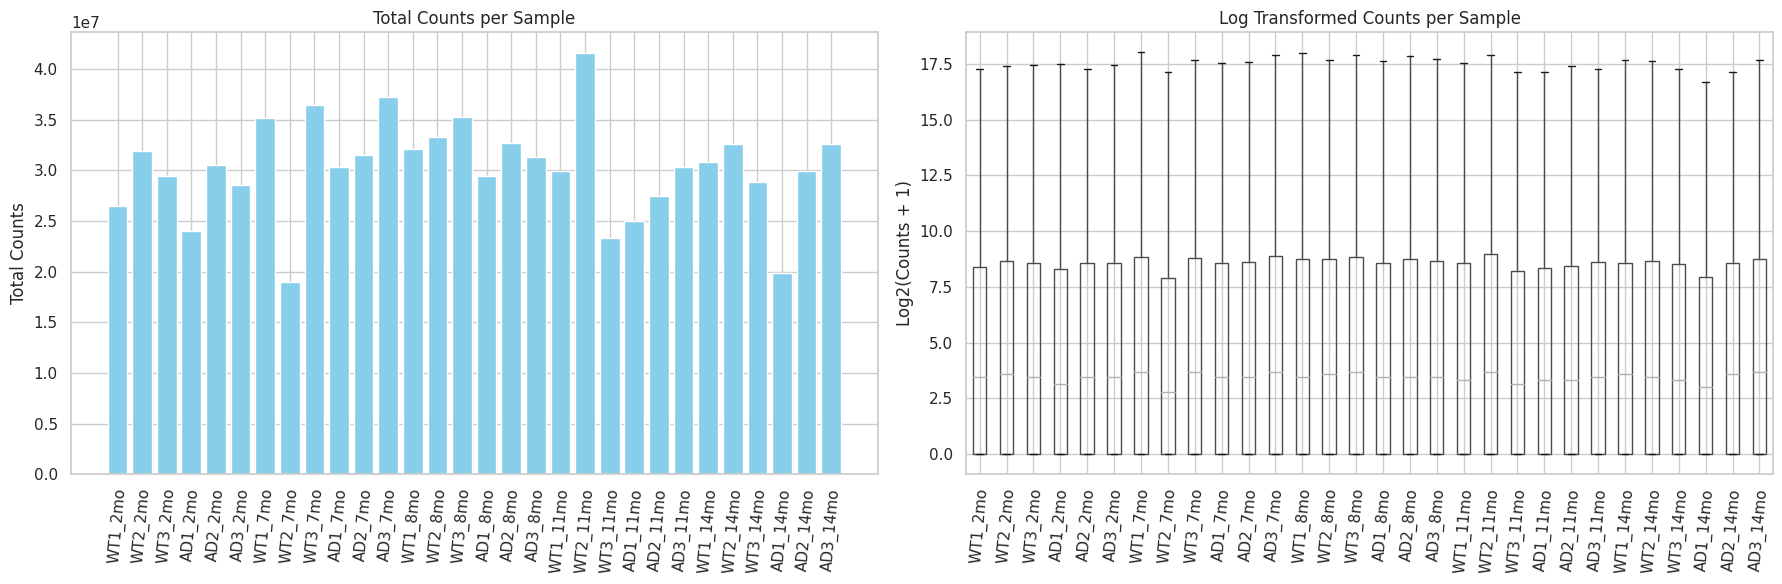

In [44]:
# calcualte total counts per sample and log transform counts
total_counts = data.sum(axis=0)
log_counts = data.apply(lambda x: np.log2(x + 1))

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# plot total counts per sample
axes[0].bar(data.columns, total_counts, color='skyblue')
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Total Counts per Sample')
axes[0].tick_params(axis='x', rotation=85)

# plot log transformed counts per sample
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

The chart on the left titled, "Total Counts Per Sample," helps visualize the overall sequencing depth across the samples. Ideally, the bars, representing the total counts, should be of similar height, indicating that sequencing depth is consistent across samples. However, our data suggests uneven sequencing depth across samples, which can impat downstream analyses since samples with higher depth may show higher expression counts, not due to biological differences but due to technical variability. This is a common issue in RNA-seq analysis, and will be addressed via data normalization later on.

The rightmost chart, titled "Log Transformed Total Per Sample," helps assess the variability and distribution of gene expression counts across samples. Log-transforming counts reduces skewness by dampening large values, allowing for more comparable distributions across samples. Here, the boxes (indicating the interquartile range) and whiskers (indicating variability outside the quartiles) appear similar across samples. This suggests that while total counts differ, log transformation has minimized variability among samples, partially masking depth differences and indicating a more consistent distribution across samples.





Now, before moving on to quality control and filtering, we'll use one last visualization to explore the similarity, or dissimilarity, between our thirty samples:



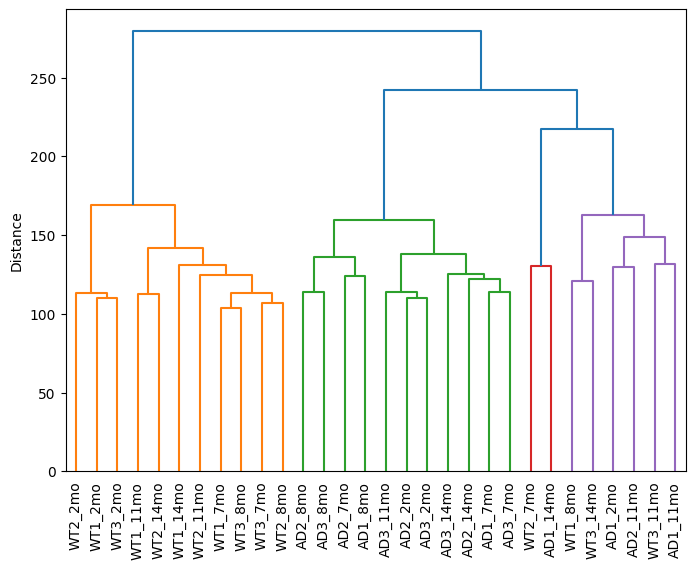

In [18]:
# perform hierarchical clustering and create dendrogram
h_clustering = linkage(log_counts.T, 'ward')
plt.figure(figsize=(8, 6))
dendrogram(h_clustering, labels=data.columns)
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

The image above shows the results of hierarchical clustering, which can be visualized via a dendrogram. When viewing a dendrogram, special attention should be paid to the cluster groupings and branches. Samples clustered together are more similar to each other, and the length of the branches (vertical lines) connecting clusters represents the distance or dissimilarity between clusters.

The chart above shows that independent of age, wild type (WT) mice tend to be clustered closer to other WT mice and transgenic (AD) mice tend to be clustered closer to other AD mice. Additionally, WT mice of a similar age tend to be clustered closer together, and likewise for AD mice. This is a good sign, as it suggests that the WT and AD groups, at large, are distinct and that there is biological variation between WT and AD mice at different time points defined by age at the time of sample collection. This should give us confidence that our downstream analyses will provide meaningful results.

# **Quality Control, Filtering, and Normalization**

The next step in our analysis is to filter out genes with low expression levels across all samples, which can introduce noise in the data. By filtering these out, you can make your results more reliable and improve your statistical power, making detecting real biological differences between conditions easier. Additionally, filtering out genes with low expression counts decreases computational load by reducing the number of genes in your dataset, making future downstream analyses faster. To determine the optimal filtering criteria, we'll plot the number of genes retained with different filtering criteria, as demonstrated below:

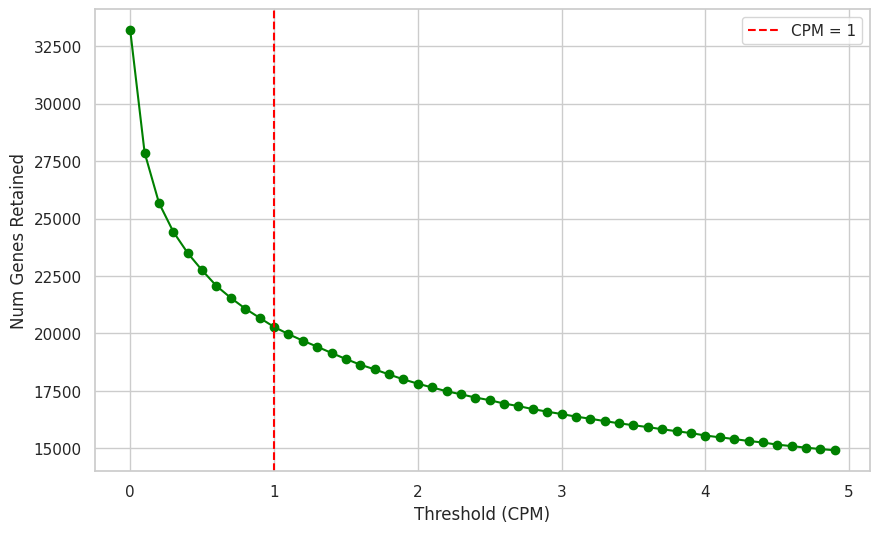

In [46]:
# plot the number of genes retained as a function of differnet CPM thresholds
def plot_genes_retained_by_cpm(data, min_samples=2):
    # convert raw counts to CPM to normalize the data
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6) #convert raw counts to CPM to normalize
    # define a range of CPM thresholds to test, from 0 to 5 with increments of 0.1
    thresholds = np.arange(0, 5, 0.1)
    # initialize list to store the # of genes retained for ea/ threshold
    genes_retained = []

    # loop through ea/ threshold value to determine the # of genes retained
    for min_cpm in thresholds:
        # create mask where CPM > min_cpm in at least min_samples samples
        mask = (cpm > min_cpm).sum(axis=1) >= min_samples
        # count # of genes that meet the criteria and append to the list
        genes_retained.append(mask.sum())

    # plot # of genes retained as a function of CPM threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, genes_retained, marker='o', color='green')
    plt.axvline(x=1.0, color='red', linestyle='--', label='CPM = 1')
    plt.xlabel('Threshold (CPM)')
    plt.ylabel('Num Genes Retained')
    plt.legend()
    plt.show()

# call function
plot_genes_retained_by_cpm(data)

Based on the data in the chart above, we'll filter genes with an expression threshold of <0.70 CPM. For many bulk RNA-seq datasets, a CPM threshold of 1 is a common filtering point, but 0.70 is slightly more lenient is justifiable given the distribution of our data.

Now, In the code block below, well perform filtering and normalization of our data, then visualize the results:

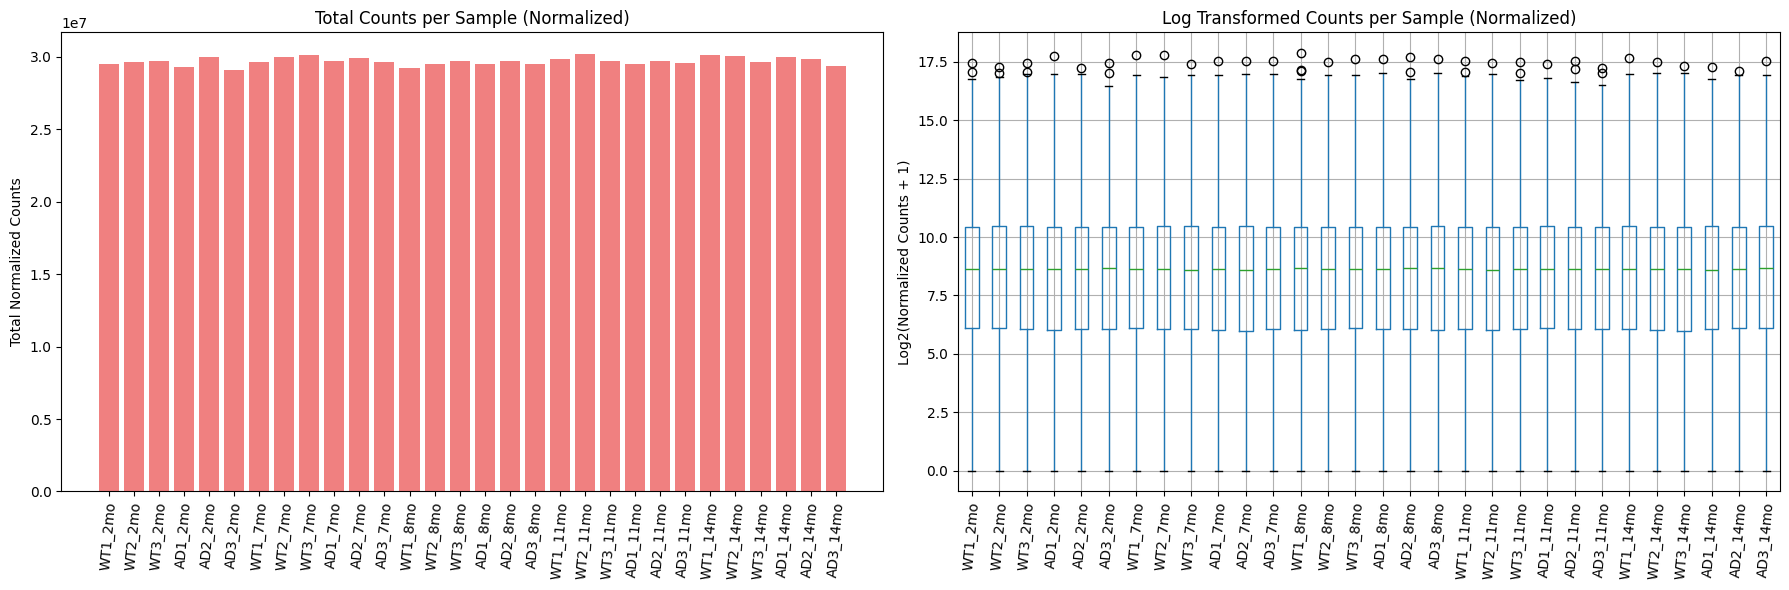

In [13]:
def filter_normalize(data, min_cpm=0.70, min_samples=2):
    # convert raw counts to CPM
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6)

    # filter genes based on CPM thresholds
    mask = (cpm > min_cpm).sum(axis=1) >= min_samples # keep genes with CPM > min_cpm in at least min_samples
    filtered_data = data[mask]  # apply filter

    # Compute geometric mean of non-zero values for each gene
    geometric_means = filtered_data.apply(lambda row: np.exp(np.log(row[row > 0]).mean()), axis=1)

    # calculate size factors by dividing each gene expression by its geometric mean
    size_factors = filtered_data.div(geometric_means, axis=0).median(axis=0)

    # normalize data by dividing each gene expression by the size factors
    normalized_data = filtered_data.div(size_factors, axis=1)

    # return normalized data as DF w/ the same index and columns as the filtered data
    return pd.DataFrame(normalized_data, index=filtered_data.index, columns=filtered_data.columns)

# overwrite data frame with filtered and normalized data
data = filter_normalize(data)

# plot distribution of data after normalization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# total normalized counts per sample
total_counts_normalized = data.sum(axis=0)
axes[0].bar(data.columns, total_counts_normalized, color='lightcoral')
axes[0].set_ylabel('Total Normalized Counts')
axes[0].set_title('Total Counts per Sample (Normalized)')
axes[0].tick_params(axis='x', rotation=85)

# log-transformed normalized counts per sample
log_normalized_data = data.apply(lambda x: np.log2(x + 1))
log_normalized_data.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Normalized Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample (Normalized)')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

# **Differential Expression Analysis**

Now that we've loaded our data and performed quality control and normalization, we can perform differential expression analysis. In this case, we will use pairwise comparisons for each time point, comparing gene expression levels between groups of wild type (WT) and transgenic (AD) mice at each age (2, 7, 8, 11, and 14 months). Each time point has matched control (WT) and experimental (AD) samples, which allows for more precise comparison by reducing biological variability and batch effects.

By conducting separate comparisons at each time point, we create five distinct analyses:
- WT_2mo vs AD_2mo,
- WT_7mo vs AD_7mo,
- WT_8mo vs AD_8mo,
- WT_11mo vs AD_11mo, and
- WT_14mo vs AD_14mo.

In the code block below, we'll perform these pairwise analyses, apply multiple testing corrections, and identify differentially expressed genes:

In [14]:
# initialize list to store results for each gene and time point
results = []

#dDefine time points and corresponding WT and AD sample groups
time_points = {
    "2mo": (['WT1_2mo', 'WT2_2mo', 'WT3_2mo'], ['AD1_2mo', 'AD2_2mo', 'AD3_2mo']),
    "7mo": (['WT1_7mo', 'WT2_7mo', 'WT3_7mo'], ['AD1_7mo', 'AD2_7mo', 'AD3_7mo']),
    "8mo": (['WT1_8mo', 'WT2_8mo', 'WT3_8mo'], ['AD1_8mo', 'AD2_8mo', 'AD3_8mo']),
    "11mo": (['WT1_11mo', 'WT2_11mo', 'WT3_11mo'], ['AD1_11mo', 'AD2_11mo', 'AD3_11mo']),
    "14mo": (['WT1_14mo', 'WT2_14mo', 'WT3_14mo'], ['AD1_14mo', 'AD2_14mo', 'AD3_14mo'])}

# loop through ea/ gene and time point to perform pairwise comparisons
for gene in data.index:
    for time_point, (wt_samples, ad_samples) in time_points.items():
        # extract data for WT and AD groups at the current time point
        control = data.loc[gene, wt_samples]
        treated = data.loc[gene, ad_samples]

        # calculate mean expression levels for WT and AD groups
        mean_control = np.mean(control)
        mean_treated = np.mean(treated)

        # compute log2 fold change, adding 1 to avoid log of 0
        log2fc = np.log2((mean_treated + 1) / (mean_control + 1))

        # perform t-test to compare WT and AD groups
        t_stat, p_val = ttest_ind(control, treated)

        # append results for the current gene and time point
        results.append({'gene': gene, 'time_point': time_point,'log2fc': log2fc,'t_stat': t_stat,'p_val': p_val})

# convert results list to a DF for easier manipulation
results_df = pd.DataFrame(results)

# convert pvals to numeric, coercing errors to NaN, then drop rows with NaN pval
results_df['p_val'] = pd.to_numeric(results_df['p_val'], errors='coerce')
results_df = results_df.dropna(subset=['p_val'])

# apply multiple testing correction w/ benjamini-hochberg
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# calculate the absolute value of log2 fold change
results_df['abs_log2fc'] = results_df['log2fc'].abs()

# filter results to identify differentially expressed genes with adjusted p-value < 0.1 and |log2fc| > 1
deg = results_df[(results_df['p_adj'] < 0.2) & (results_df['abs_log2fc'] > 1)] # I used a more lax pval here to better recapitulate the studies results

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:563: RuntimeWarning: P

The code above performs a differential expression analysis on gene expression data, and the final output, deg, is a DataFrame containing the genes that are significantly differentially expressed between the wild type (WT) and transgenic (AD) mouse groups at each time points (2,7,8,11, and 14 mo).

 Now that we have a dataframe of differentially expressed genes, we can view the distribution of absolute log fold changes, as demonstrated in the code block below:



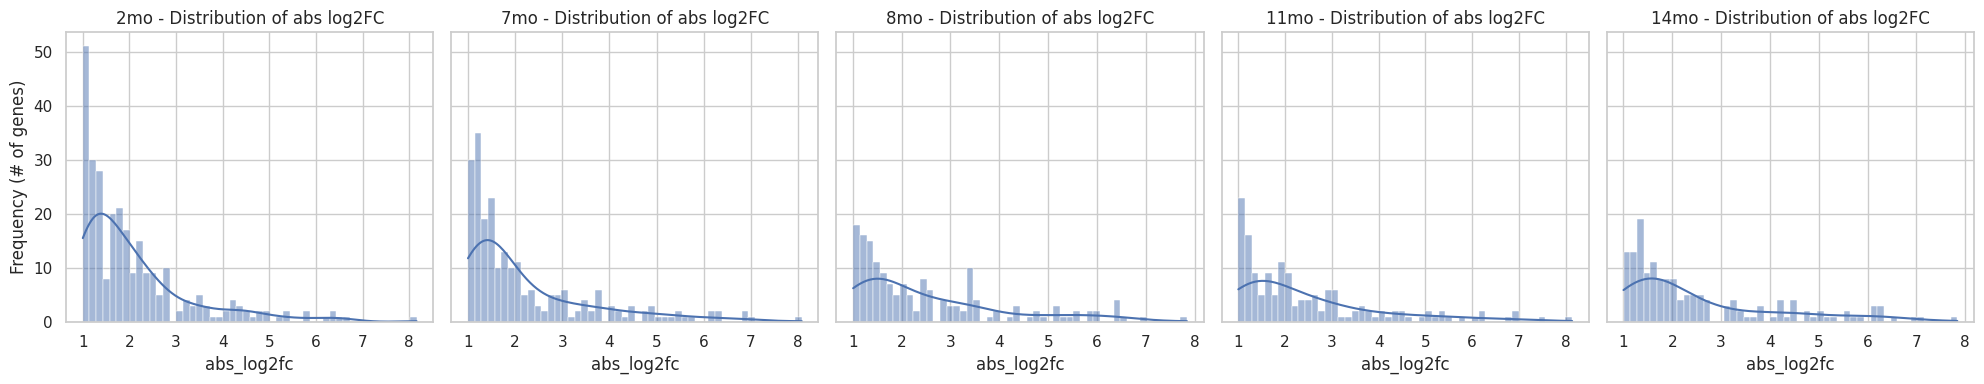

In [15]:
# define time points for analysis
time_points = ['2mo', '7mo', '8mo', '11mo', '14mo']

# set style and figure size for multiple subplots
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(time_points), figsize=(20, 4), sharey=True)

# loo[] over each time point to create a histogram in each subplot
for i, time_point in enumerate(time_points):
    # filter data for the current time point
    time_point_data = deg[deg['time_point'] == time_point]  # Adjust to match your time point column

    # plot histogram for the absolute log2 fold change at this time point
    sns.histplot(time_point_data['abs_log2fc'], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'{time_point} - Distribution of abs log2FC')
    axes[i].set_xlabel('abs_log2fc')
    axes[i].set_ylabel('Frequency (# of genes)' if i == 0 else '')  # Show y-label only on the first subplot

plt.tight_layout()
plt.show()

Notably, the image above displays the total number of genes at each absolute log-2 fold change. You'll notice that the bulk of genes hover around of low-end threshold of 1.0, with a small subset of genes having an absolute log-2 fold change of >2.0 and as high as >7.0.

Next, we'll use a bar chart to show the number of differentially expressed genes in the insular cortex as a function of age:

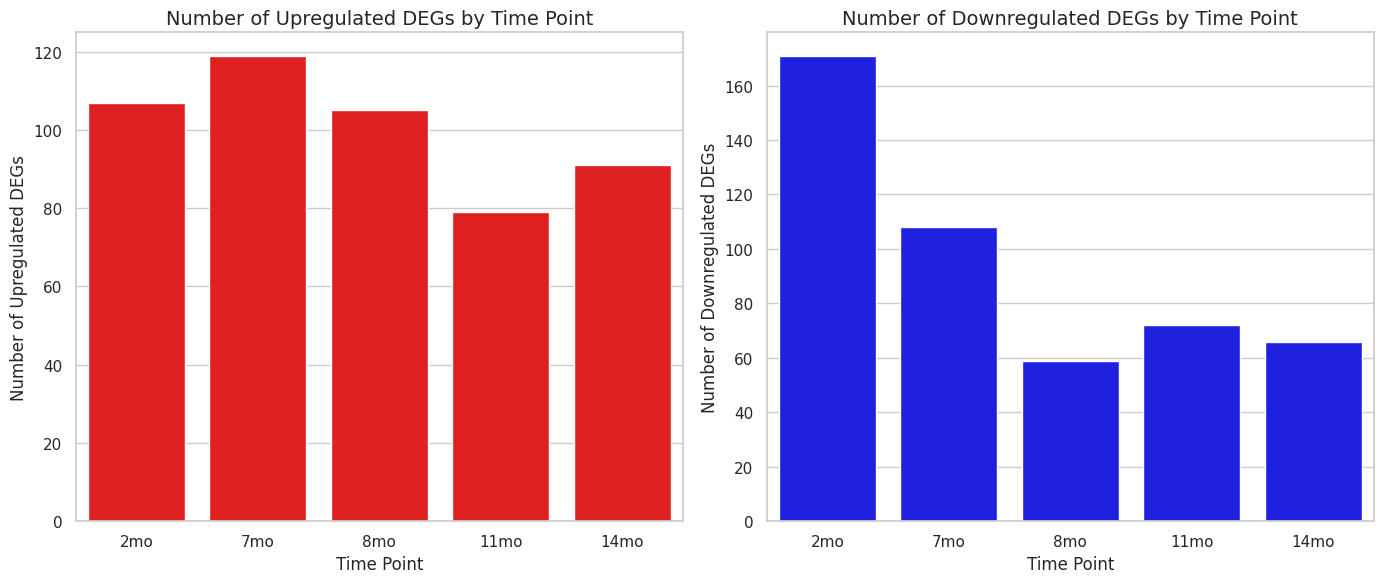

In [16]:
# Cclculate upregulated and downregulated DEGs at ea/ time point
deg_summary = []
for time_point in time_points:
    # filter DEGs for this time point
    time_point_data = deg[deg['time_point'] == time_point]

    # count upregulated and downregulated genes
    upregulated_count = (time_point_data['log2fc'] > 1).sum()
    downregulated_count = (time_point_data['log2fc'] < -1).sum()

    # append results to the summary list
    deg_summary.append({'time_point': time_point, 'direction': 'Upregulated', 'count': upregulated_count})
    deg_summary.append({'time_point': time_point, 'direction': 'Downregulated', 'count': downregulated_count})

# convert the summary to a DF for easy plotting
deg_summary_df = pd.DataFrame(deg_summary)

# plot data
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted to 1 row, 2 columns
sns.barplot(data=deg_summary_df[deg_summary_df['direction'] == 'Upregulated'], x='time_point', y='count', ax=axes[0], color='red')
axes[0].set_title('Number of Upregulated DEGs by Time Point', fontsize=14)
axes[0].set_xlabel('Time Point', fontsize=12)
axes[0].set_ylabel('Number of Upregulated DEGs', fontsize=12)
sns.barplot(data=deg_summary_df[deg_summary_df['direction'] == 'Downregulated'], x='time_point', y='count', ax=axes[1], color='blue')
axes[1].set_title('Number of Downregulated DEGs by Time Point', fontsize=14)
axes[1].set_xlabel('Time Point', fontsize=12)
axes[1].set_ylabel('Number of Downregulated DEGs', fontsize=12)
plt.tight_layout()
plt.show()

As you can see in the chart above, the number of genes upregulated in the transgenic Alzheimer’s disease (AD) mice compared to wild-type (WT) mice across the time points of 2, 7, 8, 11, and 14 months is approximately 110, 120, 110, 80, and 90 genes, respectively. In contrast, the pattern for downregulated genes shows counts of approximately 160, 105, 60, 70, and 65.

Both upregulated and downregulated genes exhibit distinct temporal trends. Upregulated genes experience a small increase from 2 to 7 months, peaking at 7 months, followed by a decline from 7 months onward, with the most significant decrease occurring between 8 onward. Conversely, downregulated genes peak at 2 months and then decrease steadily over time, with the largest reduction happening between 2 and 7 months.

These temporal trends contrast with the reported cognitive decline in 3xTG-AD mice, where symptoms manifest progressively with age, particularly around 7 to 8 months. Thus, the data suggest that certain transcriptomic changes associated with gene upregulation coincide with the onset of cognitive symptoms, while other changes related to downregulation occur at earlier stages, well before noticeable behavioral and cognitive decline.

These observations lead me to generate two hypothesis:

1. Hypothesis 1: The transient increase in upregulated genes between 2 and 7 months indicates a compensatory response to early neurodegenerative processes that may fail to sustain cognitive function as the disease progresses.

2. Hypothesis 2: The consistent downregulation of genes from 2 months onward may reflect a decline in neuroprotective pathways, contributing to cognitive impairment before observable behavioral changes.

I'm particularly interested in hypothesis 2 given that the observed patterns in the 3xTG-AD mice may parallel findings in human studies, where alterations in gene expression can also precede the clinical onset of cognitive decline. In humans, early changes in gene expression, particularly in inflammatory and neuroprotective pathways, have been associated with preclinical stages of Alzheimer’s disease. Understanding these temporal gene expression changes in animal models can enhance our comprehension of similar processes in humans and potentially inform therapeutic strategies aimed at intervening before significant cognitive decline occurs.

Later on we'll employ functional enrichment analysis, which can provide valuable insights into the biological processes and pathways associated with the differentially expressed genes (DEGs). But first, we'll explore additional visualizations of differentially expressed genes.



# **Visualizing Differenially Expressed Genes**

The first visualization we'll use to understand our data is a volcano plot. A volcano plot is a type of scatter plot commonly used in genomics and other areas of bioinformatics to visualize the results of differential expression analysis and help identify statistically significant changes in gene expression between different conditions. In the code block below, I'll demonstrate how to create a volcano plot using our data frame of filtered differentially expressed genes.

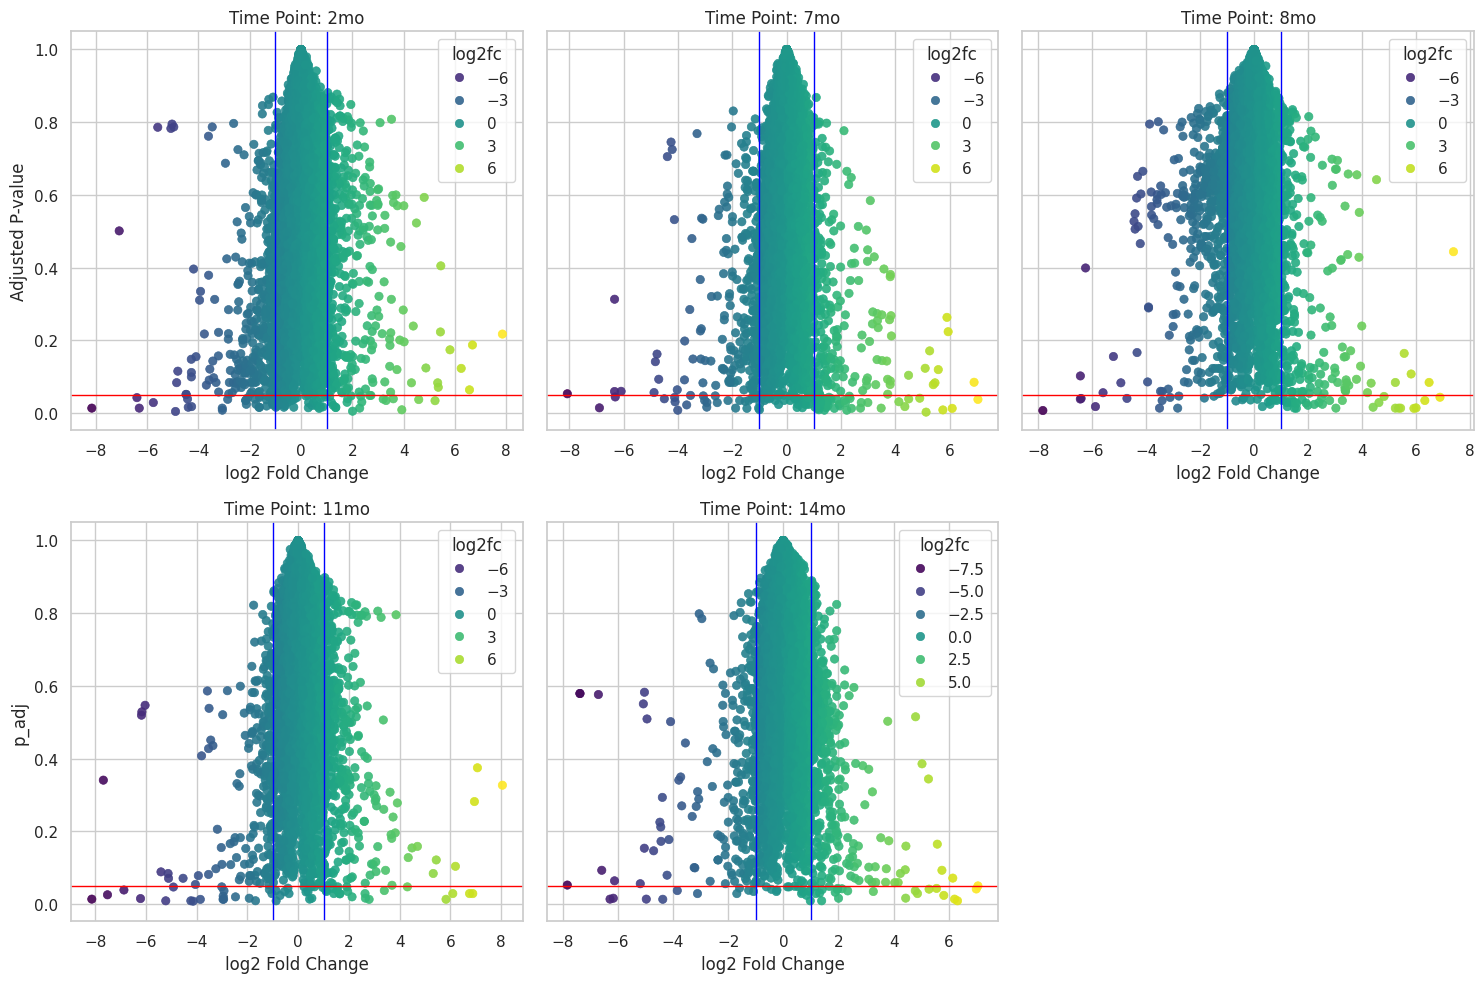

In [17]:
# create subplots
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 5), sharey=True)
axes = axes.flatten()

# loop through each time point and create a scatter plot
time_points = results_df['time_point'].unique()  # Get unique time points
for ax, time_point in zip(axes, time_points):
    # filter data for the current time point
    time_point_data = results_df[results_df['time_point'] == time_point]

    # create  scatter plot
    sns.scatterplot(data=time_point_data, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None, ax=ax)

    # add horizontal and vertical lines and set titles/labels
    ax.axhline(y=0.05, color='red', linestyle='-', linewidth=1)
    ax.axvline(x=1, color='blue', linestyle='-', linewidth=1)
    ax.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
    ax.set_title(f'Time Point: {time_point}')
    ax.set_xlabel('log2 Fold Change')

axes[0].set_ylabel('Adjusted P-value')

# hide unused subplots and adjust spacing
for ax in axes[len(time_points):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

As you can see in the image above, our volcano plot combines two critical pieces of information for each gene: the magnitude of change (fold change) and the statistical significance (p-value) of that change.

Specifically, the x-axis on this graph shows the log2 fold change between the control and experimental samples in our pairwise analysis. A positive value indicates an upregulation of a gene in the experimental group compared to the control, and a negative value represents downregulation of a gene in the experimental group compared to the control. Additionally, the y-axis shows the significance of said change in gene expression.

Thus, when viewing this graph, we are most interested in the two boxes formed in the lower left and lower right corners, which represent down-regulated and up-regulated genes with high statistical significance. This type of chart also allows us to see how changing our criteria for defining differentially expressed genes can impact the total number of genes in our dataset.



# **Functional Enrichment Analysis**

### Gene Ontology (GO) Analysis

Now that we've identified a number of differentially expressed genes, we'll perform a series of functional enrichment analyses, which allow us to identify and interpret the biological functions, processes, and pathways that are overrepresented or significant in our list of differenrentially expressed genes, thus helping us uncover Amilioride's mechansm of action.

The first analysis we'll explore is Gene Ontology (GO) analysis, which categorizes differentially expressed genes according to their associated biological processes, cellular components, and molecular functions. This categorization is based on a structured, hierarchical vocabulary known as the Gene Ontology, which systematically describes gene functions.

While differential expression analysis identifies genes that are up- or down-regulated in response to an intervention, treatment, or drug regimen, GO analysis takes this a step further by linking these genes to broader biological contexts. By grouping genes into functional categories, GO analysis can reveal which biological processes, molecular functions, or cellular components are impacted, offering a more detailed understanding of the mechanisms through which an intervention, treatment, or drug exerts its effects.

Now, I'll show you how to perform GO analysis, as demonstrated in the code block below:

<ipython-input-27-46ce29946432>:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


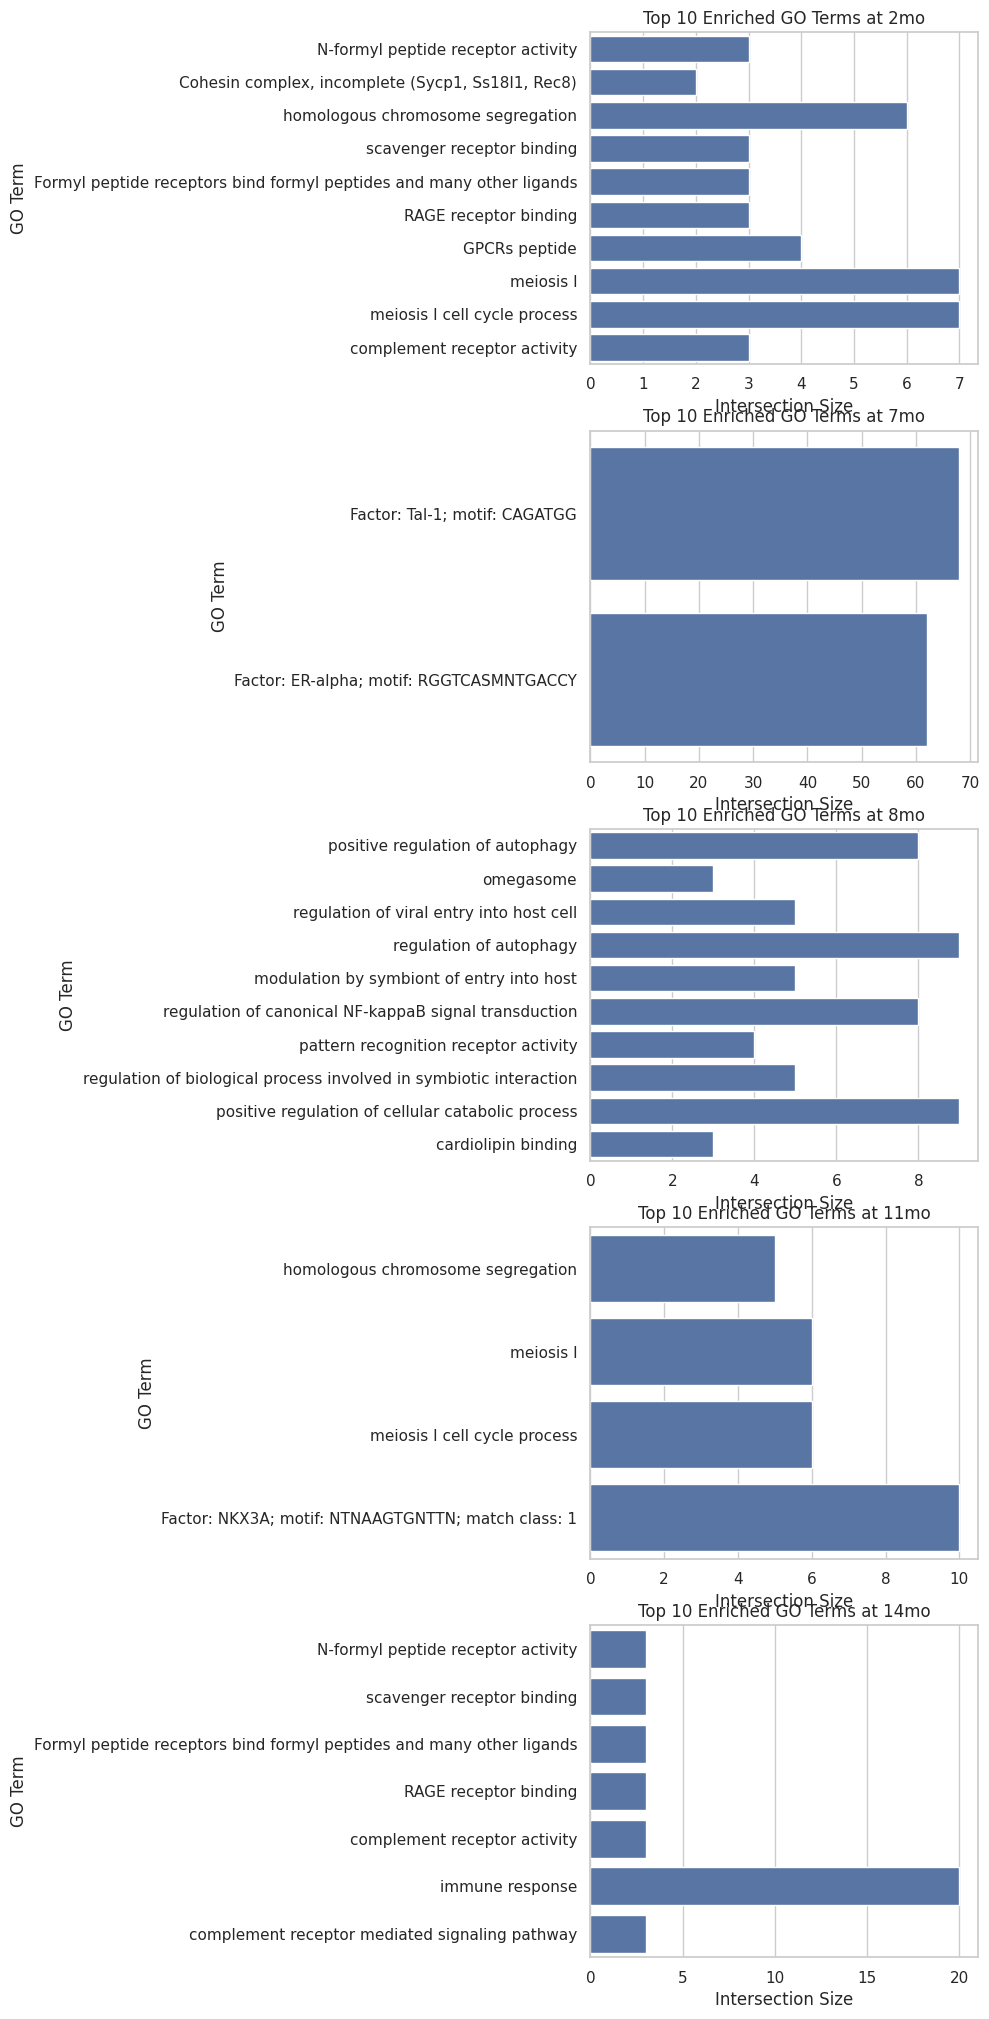

In [27]:
# initialize GProfiler
gp = GProfiler(return_dataframe=True)

# create a list to hold results for ea/ time point
go_results_by_time = {}

# loop through ea/ time point and perform GO analysis
for time_point in results_df['time_point'].unique():
    # filter DEGs for the current time point
    time_point_degs = deg[deg['time_point'] == time_point]

    # extract significant genes
    significant_genes = time_point_degs['gene'].tolist()

    if significant_genes:
        # if there are sig genes, erform functional enrichment analysis
        go_results = gp.profile(organism='mmusculus', query=significant_genes)  # Specify mouse organism
        go_results_by_time[time_point] = go_results  # Store results by time point

# create subplots for GO analysis results
num_rows = 5
num_cols = 1
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 5))
axes = axes.flatten()

# loop through each time point and create a bar plot
for ax, (time_point, go_results) in zip(axes, go_results_by_time.items()):
    # Plot the top 10 enriched GO terms
    sns.barplot(x='intersection_size', y='name', data=go_results.head(10), ax=ax)  # Adjust 'intersection_size' as needed
    ax.set_title(f'Top 10 Enriched GO Terms at {time_point}')
    ax.set_xlabel('Intersection Size')
    ax.set_ylabel('GO Term')

# hide unused subplots
for ax in axes[len(go_results_by_time):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

The gene ontology (GO) analysis results above offer significant insights into the progression of AD related pathology in the 3xTG-AD mice, which we'l explore in the next section.

# **Connecting The Dots**

In our analysis of transgenic Alzheimer’s disease (AD) mice (3xTG-AD) compared to wild type (WT) mice at various time points (2, 7, 8, 11, and 14 months of age), we observed distinct patterns of gene expression. Specifically, upregulated genes in the AD mice showed an increase from 2 to 7 months, peaking at approximately 120 genes before declining, with significant decreases between 8 and 14 months. Conversely, the number of downregulated genes peaked at 2 months, with around 160 genes, and consistently decreased over time, culminating in counts as low as 65 genes by 14 months. This suggests that the dynamics of gene expression differ throughout the disease progression timeline, potentially correlating with the onset of cognitive decline, which notably begins to manifest around 7 to 8 months in 3xTG-AD mice.

These observations led us to formulate two hypotheses:

1. The transient increase in upregulated genes between 2 and 7 months signifies a compensatory response to early neurodegenerative processes that may become insufficient as the disease progresses.

2. The consistent downregulation of genes from 2 months onward indicates a decline in neuroprotective pathways, contributing to cognitive impairment before observable behavioral changes.

To further explore these hypotheses, we conducted functional enrichment analysis using Gene Ontology (GO) terms to gain insights into the biological processes associated with the differentially expressed genes (DEGs) at each age. The identified GO terms provide additional context to the transcriptomic changes observed in the AD mice, particularly supporting Hypothesis 2 regarding neuroprotective pathways.

At the 2-month time point, the identified GO terms, including "N-formyl peptide receptor activity," "scavenger receptor binding," and "complement receptor activity," suggest an early inflammatory response. Notably, Formyl peptide receptor 2 (FPR2) mediates the cytotoxic effects of the β amyloid peptide Aβ42 and serves as a receptor for humanin, a peptide that protects neuronal cells from damage caused by Aβ42. This aligns with hypothesis 2, which surmises that neuroprotective genes may be most active early on, and decline over time. Additionally, at 2mo we see enrichment of processes related to scavenger receptors, which bind to amyloid-β (Aβ) fibrils, and the RAGE receptor, which is known to bind Aβ, further implicating the immune system in the early neurodegenerative processes. The identification of an incomplete cohesin complex (Sycp1, Ss18l1, Rec8) also suggests potential issues in sister chromatid cohesion that may affect cell division and genomic stability.


By 7 months, the emergence of terms like "positive regulation of autophagy" and "regulation of canonical NF-kappaB signal transduction" indicates a shift toward managing cellular stress and damage. The upregulation of autophagy-related genes suggests a cellular effort to clear damaged proteins, essential for maintaining cellular health amid neurodegeneration. Furthermore, the presence of factors such as TAL1, a transcription factor crucial for hematopoiesis, and Estrogen Receptor Alpha (ERα), which co-localizes with neurofibrillary tangles in AD brains, points to significant regulatory influences on neuronal health. However, the ongoing downregulation of neuroprotective pathways suggests that these compensatory mechanisms may not suffice to preserve cognitive function.

The GO terms at 8 months further emphasize autophagy and cellular catabolic processes, reinforcing the continued attempts to regulate cellular homeostasis. The regulation of NF-κB is particularly noteworthy, as this transcription factor is implicated in neuroinflammation and AD progression. Targeting NF-κB overexpression may represent a promising therapeutic approach for mitigating neuroinflammation, modulating Aβ production, and promoting neuronal survival. Additionally, the identification of pattern recognition receptor (PRR) activity highlights how amyloid-beta oligomers and fibrils activate the innate immune system, which can lead to neuroinflammation and cognitive decline. The continued emphasis on autophagy and positive regulation of cellular catabolic processes suggests that these pathways may be the last line of defense against ongoing neurodegeneration.


At 11 months, the identification of gene ontology (GO) terms such as "homologous chromosome segregation" and "meiosis I" indicates substantial cellular dysregulation, suggesting a decline in cellular integrity that may contribute to cognitive decline. These terms point to disruptions in the normal processes of chromosome separation during cell division, potentially leading to aneuploidy or chromosomal instability in neuronal cells. The aberrant expression of meiosis-related genes in the aging brain might signify a reversion to a less stable state, possibly as a response to cellular stress or damage. Furthermore, the presence of transcription factor NKX3A, which plays a critical role in regulating gene expression essential for neuronal growth, differentiation, and survival, highlights significant shifts in the regulatory landscape. These changes may adversely affect neuronal processes such as synaptic function and plasticity, ultimately exacerbating the neurodegenerative processes associated with cognitive decline.


Finally, the resurgence of terms like "N-formyl peptide receptor activity" and "immune response" at 14 months suggests a potential reactivation of inflammatory processes as neurodegeneration continues. The persistence of scavenger receptor binding, RAGE receptor binding, and complement receptor activity implies ongoing immune engagement, likely as an adaptive response to address the neuronal damage. The presence of complement receptor-mediated signaling pathways further indicates a sustained immune effort to manage the challenges posed by neurodegenerative processes.

In summary, the integration of GO term findings with the initial observations provides a coherent narrative regarding the temporal dynamics of gene expression in 3xTG-AD vs wild type mice from 2 months to 14 months of age. The distinct trends of upregulation of genes and downregulation of genes, particularly the sustained decline in neuroprotective pathways, align with our hypothesis that early alterations in gene expression can precede cognitive decline. Particularly when juxtaposed with behavioral and cognitive data, which does a progressive declines from ~7-8 months onward. The interplay between immune response activation and the downregulation of protective pathways also underscores the complexity of Alzheimer’s disease progression, highlighting the importance of understanding these molecular changes as they relate to cognitive outcomes in both animal models and humans.